<a href="https://colab.research.google.com/github/chaitubhure/HEADS_HOST_2023_SCS/blob/main/Predictions_on_Holdout_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Model to run predictions on unseen data

In [1]:
# Required imports to ensure below code cells are run properly
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
# Connect google drive to google colab to give access to test images, labels and model file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load model to make predictions. The model will be provided as .h5 file to implement predictions on holdout data.
model = load_model('/content/drive/MyDrive/HOST_2023_SupplyChainCompetition/vgg16_phase2.h5')

In [4]:
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # Utilizing the same preprocessing function employed in training phase

In [5]:
test = pd.read_csv('/content/drive/MyDrive/CompetitionMaterials_Phase2/Holdout_Data/final_sample_submission.csv')

In [6]:
test

,Id
0,sample_1
1,sample_2
2,sample_3
3,sample_4
4,sample_5
5,sample_6
6,sample_7
7,sample_8
8,sample_9
9,sample_10


In [7]:
test['Id'] = pd.Series(test['Id'], dtype="string")
#test['label'] = pd.Series(test['label'], dtype="string")

In [8]:
# Function to append ".png" to id column in the dataframe to traverse file directory using the filenames from id column

def append_ext(fn):
    return fn+".png"
test["Id"]=test["Id"].apply(append_ext)

In [9]:
test

,Id
0,sample_1.png
1,sample_2.png
2,sample_3.png
3,sample_4.png
4,sample_5.png
5,sample_6.png
6,sample_7.png
7,sample_8.png
8,sample_9.png
9,sample_10.png


In [10]:
# Define Home directory to provide path to test images in test generator. Your file paths may vary so use appropriate file paths here.
home_path = r'/content/drive/MyDrive/HOST_2023_SupplyChainCompetition/'

batch_size = 1

test_generator_df = test_generator.flow_from_dataframe(dataframe=test, 
                                              directory=home_path+'Holdout_Data',
                                              x_col="Id", 
                                              y_col=None,
                                              class_mode=None,
                                              target_size=(200, 200), 
                                              batch_size=batch_size,
                                              #rescale=1.0/255,
                                              shuffle=False,
                                              crop_to_aspect_ratio=True,
                                              seed=2023)

Found 10 validated image filenames.


In [11]:
vgg_preds = model.predict(test_generator_df)

10/10 [==============================] - 6s 570ms/step


In [12]:
vgg_preds

array([[9.9982542e-01],
       [9.0240152e-04],
       [1.9581550e-05],
       [9.5589828e-01],
       [1.0000000e+00],
       [9.9999893e-01],
       [1.0000000e+00],
       [9.9999899e-01],
       [1.9425629e-07],
       [8.3691691e-04]], dtype=float32)

In [13]:
# Convert raw probability values into classes

threshold = 0.5
predicted_classes = np.where(vgg_preds > threshold, 1,0)

In [14]:
predicted_classes

array([[1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0]])

# Visualize Predictions on Input Data

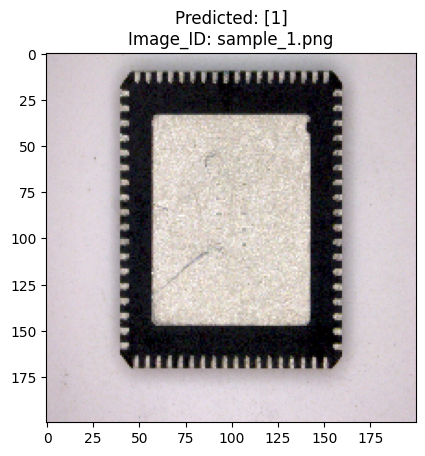

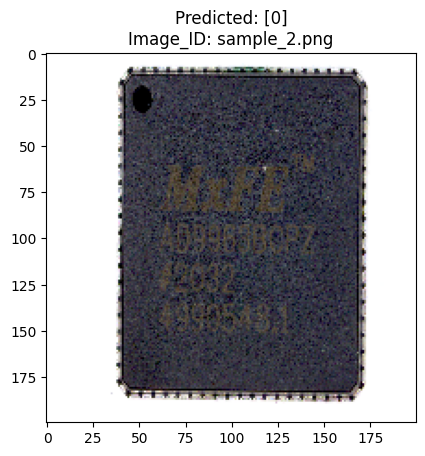

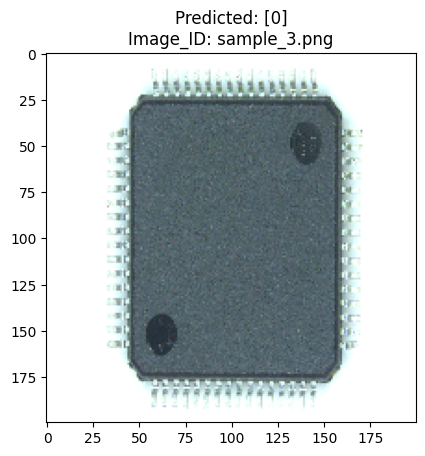

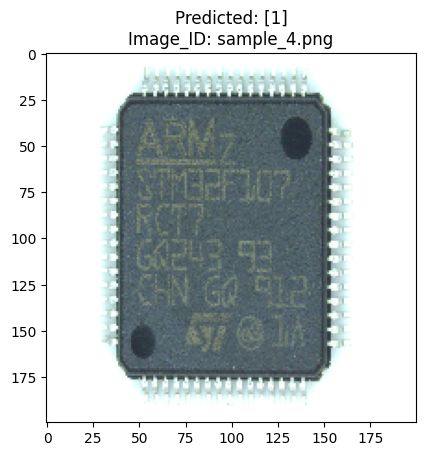

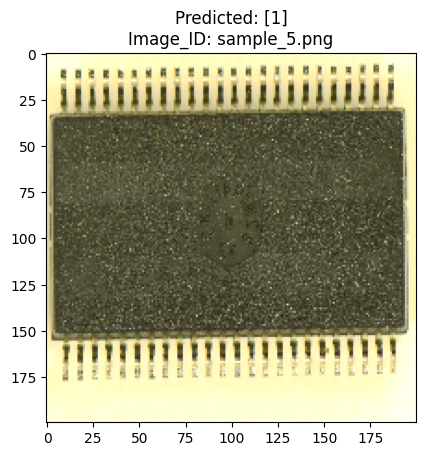

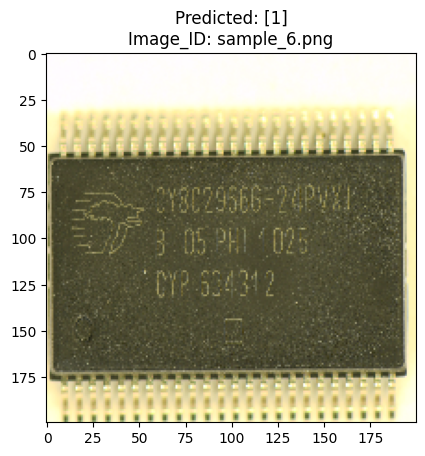

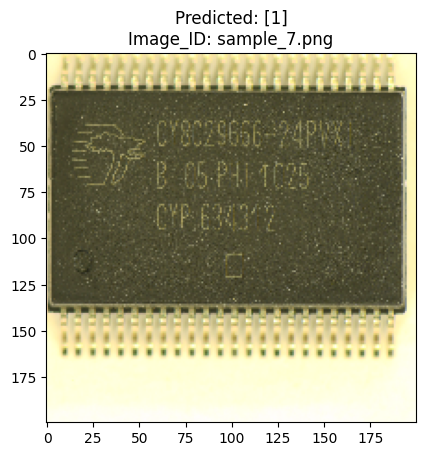

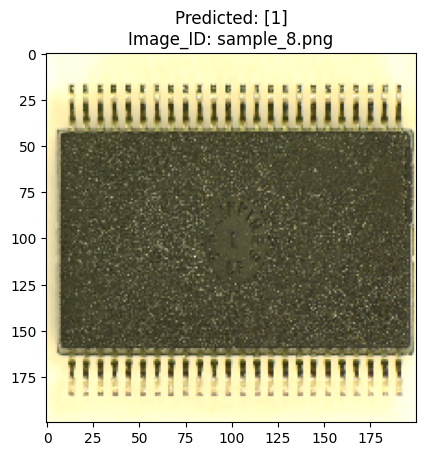

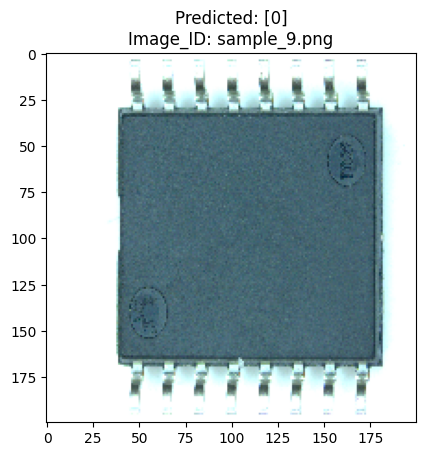

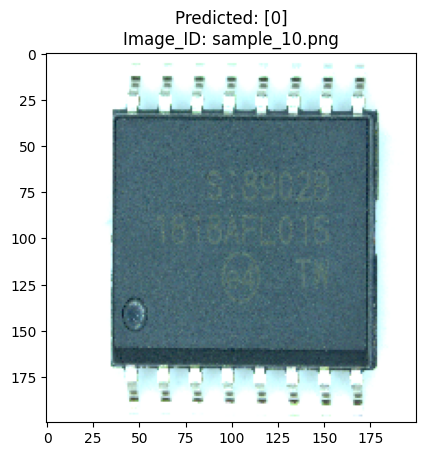

In [15]:
# Generate predictions on each image of the test data
import os
import keras.utils as image

test = pd.read_csv('/content/drive/MyDrive/CompetitionMaterials_Phase2/Holdout_Data/final_sample_submission.csv')
test['Id'] = pd.Series(test['Id'], dtype="string")
def append_ext(fn):
    return fn+".png"
test["Id"]=test["Id"].apply(append_ext)

img_nr = 0
for subdir, dirs, files in os.walk('/content/drive/MyDrive/HOST_2023_SupplyChainCompetition/Holdout_Data'):
    for file in test['Id']:
        img_file = subdir + '/' + file
        imagex = image.load_img(img_file,target_size=(200,200))
        pred_emotion = predicted_classes[img_nr]
        #real_emotion = true_classes[img_nr]
        plt.figure()
        plt.title('Predicted: ' + str(pred_emotion) + '\n' + 'Image_ID: ' + str(file))
        #plt.title('Predicted: ' + str(pred_emotion) + '\n' + 'Actual: ' + str(real_emotion) + '\n' + 'Image_ID: ' + str(file))
        plt.imshow(imagex)
        img_nr = img_nr +1

# Model Explainability. Visualize Activation Maps from 4 different layers

In [16]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.applications.inception_v3 import preprocess_input, decode_predictions

%matplotlib inline

In [17]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

In [18]:
import keras.utils as image

layer_outputs = [layer.output for layer in model.layers[1:100]]

# This is a sample image from holdout dataset. You can choose a different image and different activation layer numbers to visualize any image and any layer
# from the given model.
test_image = "/content/drive/MyDrive/CompetitionMaterials_Phase2/Holdout_Data/sample_2.png"

# Loading the image and converting it to a numpy array for feeding it to the model. Its important to use expand_dims since our original model takes batches of images
# as input, and here we are feeding a single image to it, so the number of dimensions should match for model input.
img = image.load_img(test_image, target_size=(200, 200))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr /= 255.

activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

# Names of layers and activation functions whose outputs you can visualize. Visualizing these activations help in understanding what neurons are triggered
# in the model based on certain features in the image.
layer_names = ['block1_conv2', 'block4_conv3','block5_conv3']
activ_list = [activations[0], activations[2], activations[10], activations[12], activations[17], activations[19]]

1/1 [==============================] - 1s 606ms/step


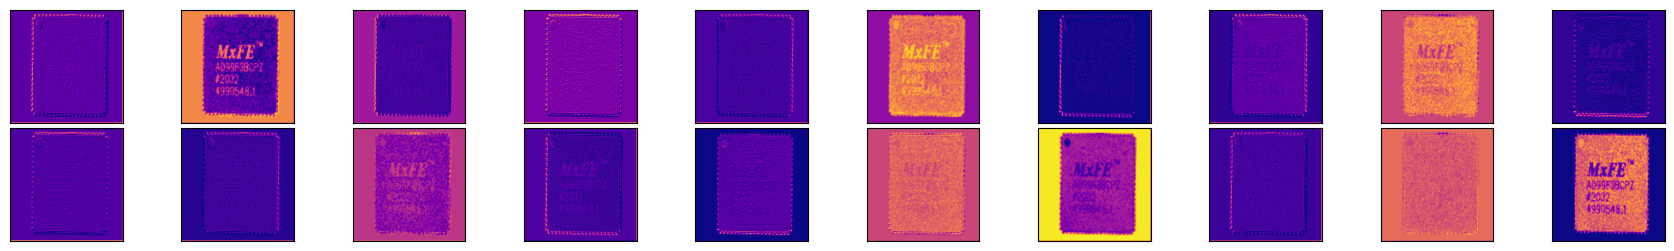

In [19]:
# Activation map for first convolution layer
fig = plt.figure(figsize=(22, 3))
for img in range(20):
    ax = fig.add_subplot(2,10, img+1)
    ax = plt.imshow(activations[0][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

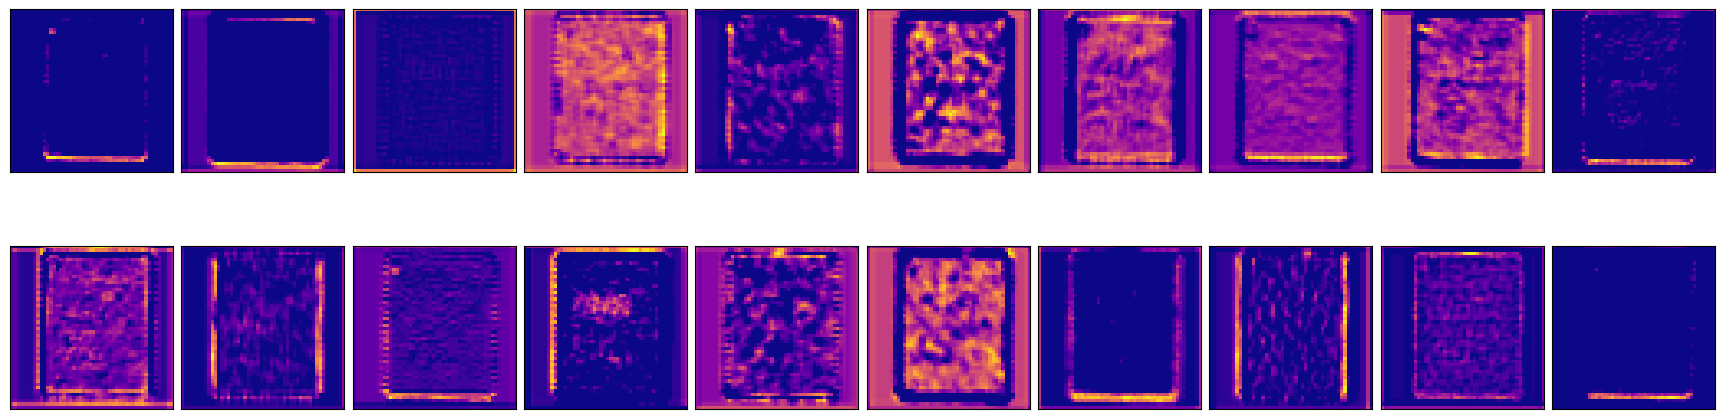

In [20]:
# Activation map for 6 convolutional layer
fig = plt.figure(figsize=(22, 6))
for img in range(20):
    ax = fig.add_subplot(2, 10, img+1)
    ax = plt.imshow(activations[6][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

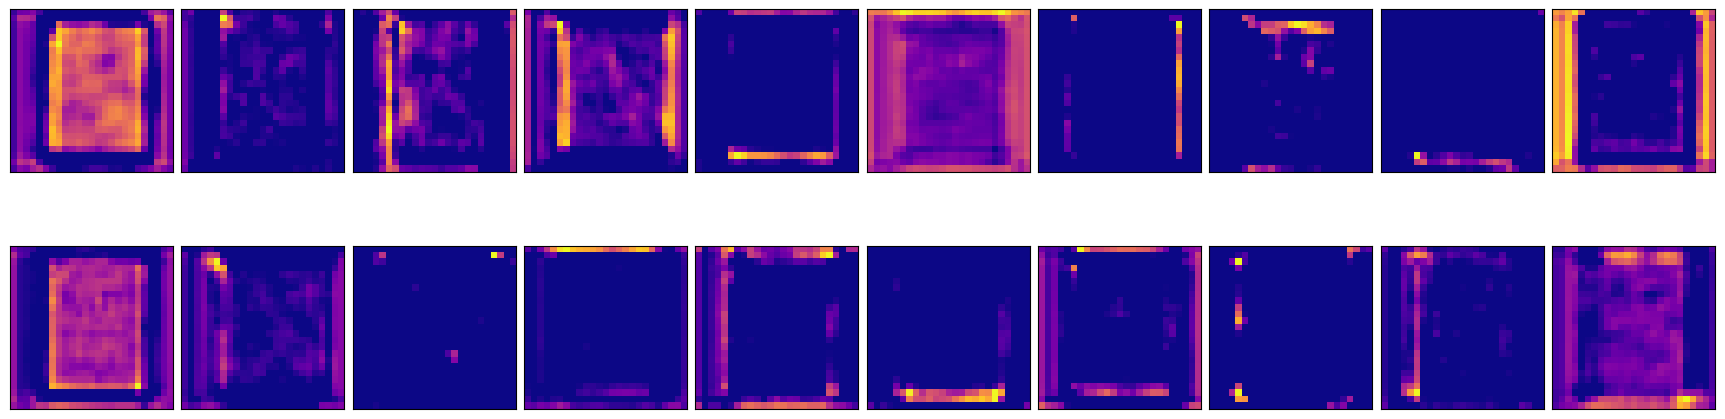

In [21]:
# Activation map for 10 convolution layer
fig = plt.figure(figsize=(22, 6))
for img in range(20):
    ax = fig.add_subplot(2, 10, img+1)
    ax = plt.imshow(activations[10][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

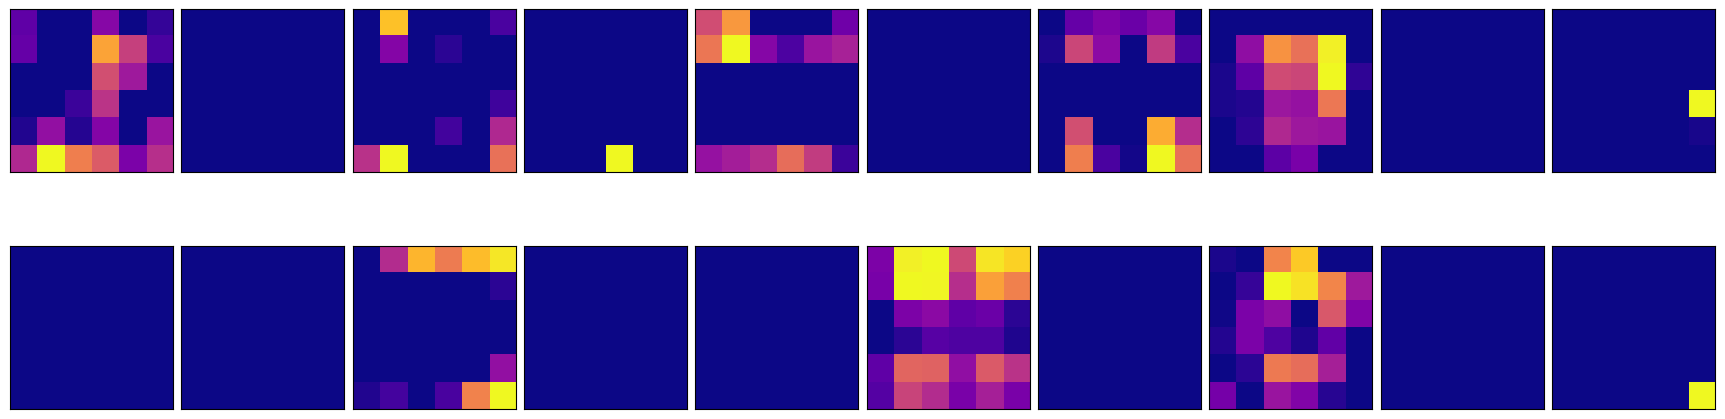

In [22]:
# Activation map for the final convolution layer
fig = plt.figure(figsize=(22, 6))
for img in range(20):
    ax = fig.add_subplot(2, 10, img+1)
    ax = plt.imshow(activations[17][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)